In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
import sys
sys.path.insert(0, '../')

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score, multilabel_confusion_matrix
from sklearn.datasets import make_multilabel_classification
from scipy.optimize import minimize

In [5]:
from sklearn.decomposition import PCA, NMF
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

True
1
0
Tesla T4


In [6]:
from tools.ramanflow.read_data import ReadData as rd
from tools.ramanflow.prep_data import PrepData as rpd

## Read the data.

In [7]:
f_sup, _ = rd.read_data("../data/20220422 SERS data generation/analyte 1/mapping50X50/1_3min_b3_50X50_spectral_mapping_1.tif")

In [8]:
_, colloids = rd.read_data("../data/20220422 SERS data generation/colloidal/mapping10X10/colloidal_3min_b3_10X10_500ms_spectral_mapping.tif")

In [9]:
spectra_dataset = rd.read_data("dataset.npy")

## Do stuff.  
Check if the dot product between the spectra and the colloidal spectra can help to remove colloidal background.

In [ ]:
def dot_product_along_axis(row):
    return np.dot(row, colloids[0])

In [ ]:
# Apply the custom function along axis 1
result = np.apply_along_axis(dot_product_along_axis, axis=1, arr=spectra_dataset)

In [ ]:
result_mid = result / (np.linalg.norm(colloids[0], ord=2) ** 2) * colloids[0]

ValueError: ignored

In [ ]:
result_final = result_mid * colloids[0]

ValueError: ignored

In [ ]:
print(result[0])

75422559.5931481


In [ ]:
proj = (np.dot(colloids[0], spectra_dataset, axis=0)) / (np.linalg.norm(test_coll,ord=2)**2) * test_coll

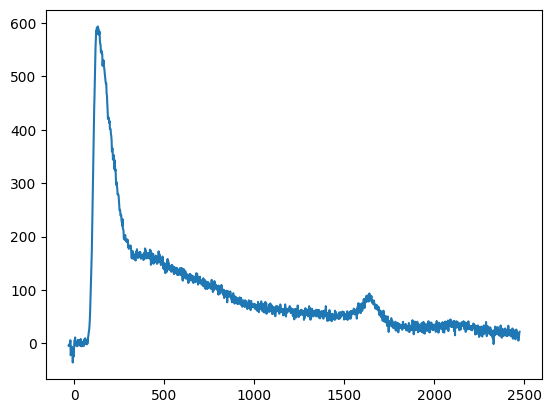

In [ ]:
plt.plot(f_sup, np.mean(colloids, axis=0))

In [ ]:
test_car = np.copy(spectra_dataset[0])
test_coll = np.copy(colloids[0])
# test_car = test_car / np.max(test_car)
# test_coll = test_coll / np.max(test_coll)

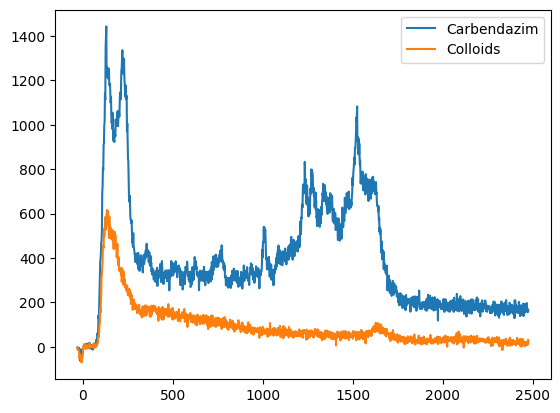

In [ ]:
plt.plot(f_sup, test_car, label="Carbendazim")
plt.plot(f_sup, test_coll, label="Colloids")
# plt.plot(f_sup, test_car - test_coll, label="Carbendazim - Colloids")
plt.legend()
plt.show()

In [ ]:
test_car

array([-0.002079  , -0.00831601, -0.00970201, ...,  0.10810811,
        0.10949411,  0.11226611])

In [ ]:
test_coll

array([-0.00811688, -0.01136364, -0.01623377, ...,  0.01623377,
        0.05032468,  0.03084416])

In [ ]:
print(test.shape)
print(colloids.shape)

(1600,)
(100, 1600)


In [ ]:
proj = (np.dot(test_coll, test_car)) / (np.linalg.norm(test_coll,ord=2)**2) * test_coll

In [ ]:
print(proj)

[-14.89917335 -20.8588427  -29.79834671 ...  29.79834671  92.37487479
  56.61685874]


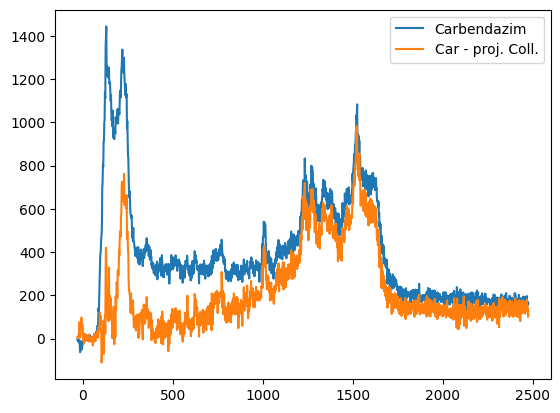

In [ ]:
plt.plot(f_sup, test_car, label="Carbendazim")
# plt.plot(f_sup, proj / 1.6, label="Proj")
# plt.plot(f_sup, test_coll, label="Colloids")
plt.plot(f_sup, test_car - (proj / 1.6), label="Car - proj. Coll.")
plt.legend()
plt.show()

In [ ]:
# Print the shape of the dataset
print(spectra_dataset.shape)

In [ ]:
label_mask = np.zeros((73312))

label_mask[0:7500] = 1
label_mask[7500:15000] = 2
label_mask[15000:22500] = 3
label_mask[22500:30000] = 4
label_mask[30000:37500] = 5
label_mask[37500:44668] = 6
label_mask[44668:47740] = 7
label_mask[47740:] = 8

In [11]:
label_mask = np.zeros((73312, 4))

label_mask[0:7500] = [1, 0, 0, 0]
label_mask[7500:15000] = [0, 1, 0, 0]
label_mask[15000:22500] = [0, 0, 1, 0]
label_mask[22500:30000] = [1, 1, 0, 0]
label_mask[30000:37500] = [1, 0, 1, 0]
label_mask[37500:44668] = [0, 1, 1, 0]
label_mask[44668:47740] = [1, 1, 1, 0]
label_mask[47740:] = [0, 0, 0, 1]

## Normalize spectra

Normaliza the spectra between 0 and 1.

In [13]:
max_values = np.max(spectra_dataset, axis=1)  # Get the maximum value for each spectrum
normalized_spectra = spectra_dataset / max_values[:, np.newaxis]  # Divide each spectrum by its maximum value

/tmp/ipykernel_35155/3677515084.py:2: RuntimeWarning: invalid value encountered in divide
  normalized_spectra = spectra_dataset / max_values[:, np.newaxis]  # Divide each spectrum by its maximum value


Remove all the NaN values.

In [14]:
normalized_spectra_wo_nan = normalized_spectra[~np.isnan(normalized_spectra).any(axis=1)]

# Remove the values with the same index from the label mask
label_mask_wo_nan = label_mask[~np.isnan(normalized_spectra).any(axis=1)]

Remove allt the Negative values.

In [15]:
# Apply the same mask to label_mask and normalized_spectra arrays
label_mask_wo_negative = label_mask_wo_nan[~(normalized_spectra_wo_nan[:, 50:] < 0).any(axis=1)]
normalized_spectra_wo_negative = normalized_spectra_wo_nan[~(normalized_spectra_wo_nan[:, 50:] < 0).any(axis=1)]

In [ ]:
(normalized_spectra[0][50:] < 0).any()

False

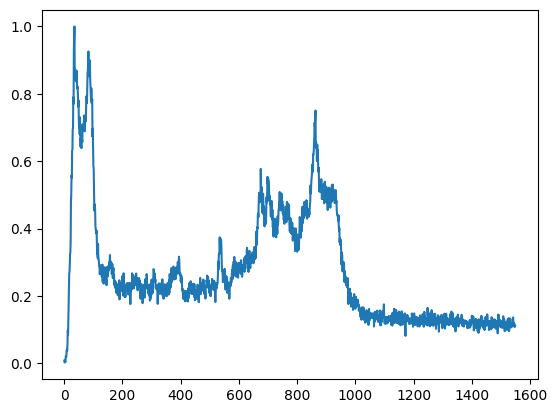

In [ ]:
plt.plot(normalized_spectra[0][50:])

In [16]:
# Assuming you have label_mask_wo_negative after removing entries with negative values

# Count the occurrences of each label in the remaining data
label_counts = np.sum(label_mask_wo_negative, axis=0)

# Calculate the total number of remaining entries
total_entries = label_mask_wo_negative.shape[0]

# Calculate the percentage of each label
label_percentages = (label_counts / total_entries) * 100

# Display or use the label_percentages as needed
print("Label Percentages:")
for i, percentage in enumerate(label_percentages):
    print(f"Label {i+1}: {percentage:.2f}%")

Label Percentages:
Label 1: 31.54%
Label 2: 33.40%
Label 3: 31.82%
Label 4: 39.66%


In [17]:
normalized_spectra_wo_negative.shape

(64218, 1600)

In [ ]:
# plt.plot(normalized_spectra_wo_nan[1, 100:])
normalized_spectra_wo_nan[1, 100:]

array([0.72633745, 0.73662551, 0.71604938, ..., 0.10185185, 0.09670782,
       0.0936214 ])

In [ ]:
signals_wo_nan = signals[~np.isnan(normalized_spectra).any(axis=1)]

In [ ]:
singals_wo_neg = signals_wo_nan[~(normalized_spectra_wo_nan[:, 50:] < 0).any(axis=1)]

## Create the programmable curves for each class for PCA and NMF.

In [18]:
signals = np.zeros((73312, 5))

# Generate signals
for step in range(4):
    for i in range(73312):
        if label_mask[i][step] == 1:
            # Count the number of active labels at this step
            num_active_labels = sum(label_mask[i])
            signals[i][step] = 1 / num_active_labels if num_active_labels > 0 else 1

In [22]:
signals = signals.T

In [19]:
# Define class labels
class_labels = ["Carbendazim", "Thiacloprid", "Acetamiprid", "MG"]

AttributeError: 'numpy.ndarray' object has no attribute 'set_ylim'

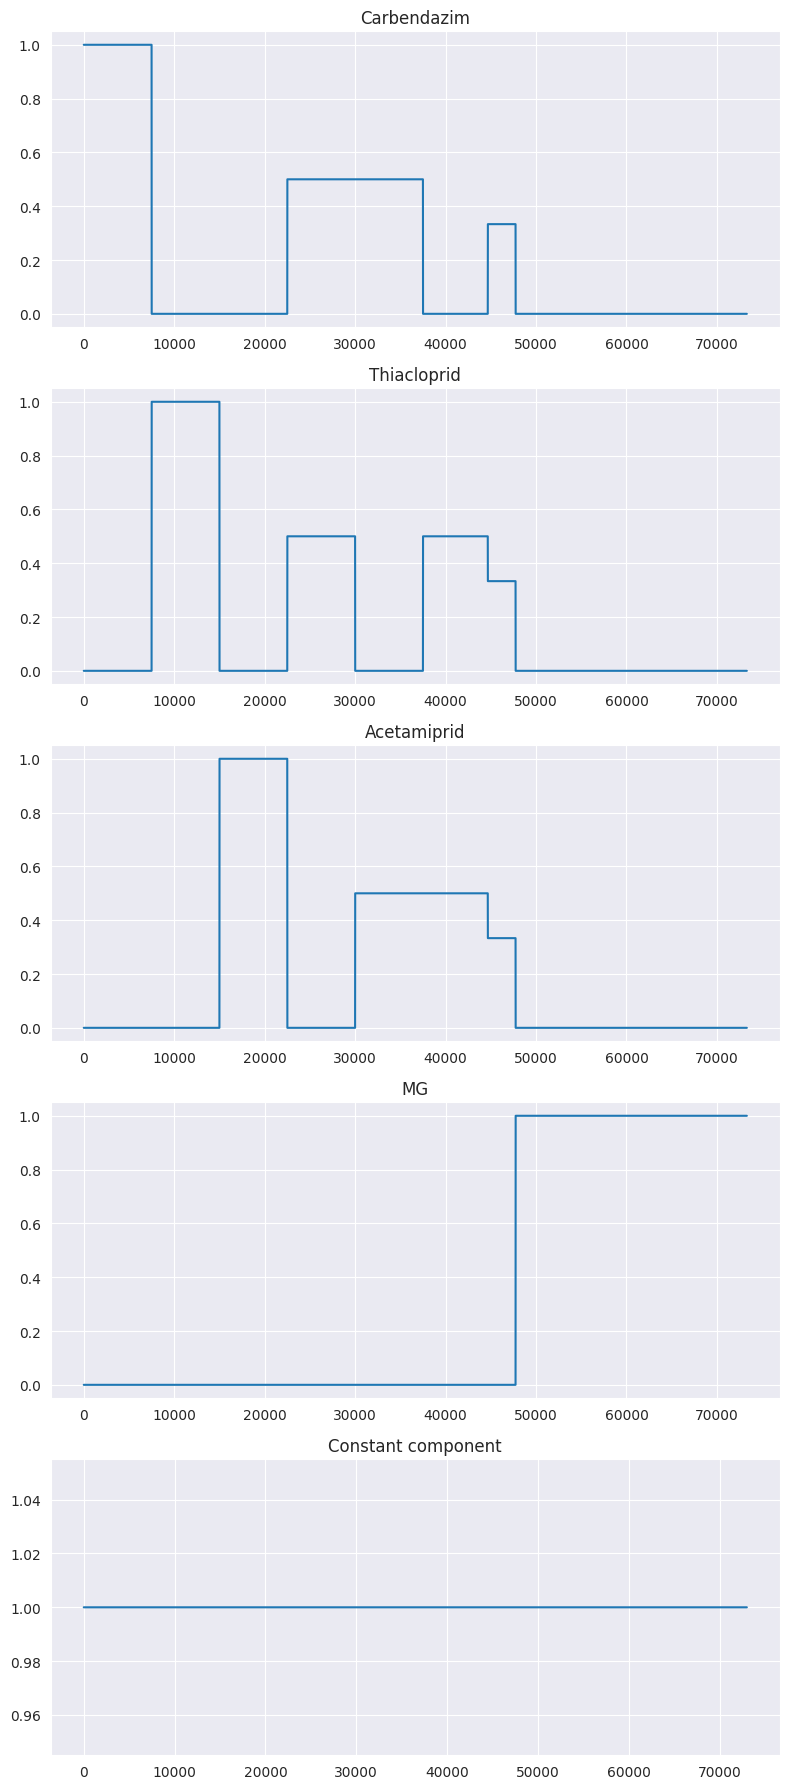

In [32]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 18))

# Define labels for the subplots
# labels = ["Label 1", "Label 2", "Label 3", "Label 4"]

# Plot each entry in the 'signals' array in separate subplots
for i in range(4):
    axes[i].plot(signals[i])
    axes[i].set_title(class_labels[i])
    # axes[i].set_xlabel("Data Point")
    # axes[i].set_ylabel("Signal Value")

# plot a step function at amplitude 0 for 73000 points using np.arange(73000)
axes[4].plot(np.ones(73000))
axes[4].set_title("Constant component")

# Adjust spacing between subplots
plt.tight_layout()

axes.set_ylim(-1, 1)

# Show the plot
plt.show()

In [ ]:
#minimize function define
# t_data: pca_components from t_dataN_PCA
# time_data_input: programming curve
def f3(initial_guess,t_data,time_data_input):
    result = np.zeros(time_data_input.size)
    for i in range(len(initial_guess)):
        result += np.dot(initial_guess[i],t_data[:,i])
    return np.linalg.norm(result-time_data_input)

In [ ]:
f_dataN_PCA.shape

(72782, 4)

In [ ]:
#Use minimize function
result = minimize(f3, [1, 1, 1, 1],args=(f_dataN_PCA, signals_wo_nan.T[-1] * 0.01), tol = 10**-12)

In [ ]:
dir(result)

['fun',
 'hess_inv',
 'jac',
 'message',
 'nfev',
 'nit',
 'njev',
 'status',
 'success',
 'x']

In [ ]:
# plt.plot(result.x)
result.x / np.linalg.norm(result.x)

array([ 0.83641786, -0.23556433, -0.49035201,  0.06685435])

In [ ]:
f_dataN_PCA.shape

(72782, 4)

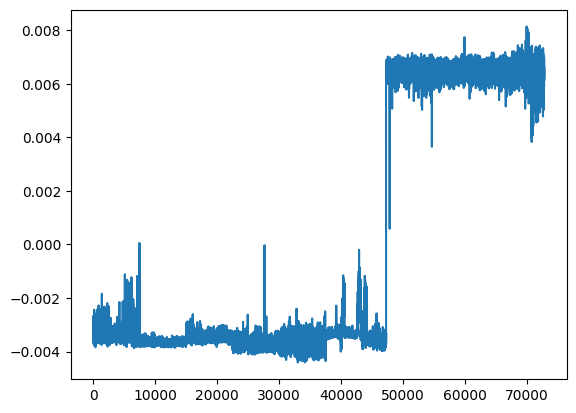

In [ ]:
# t_dataN_PCA.shape
plt.plot(np.dot(result.x, f_dataN_PCA.T))

## Multilabel test

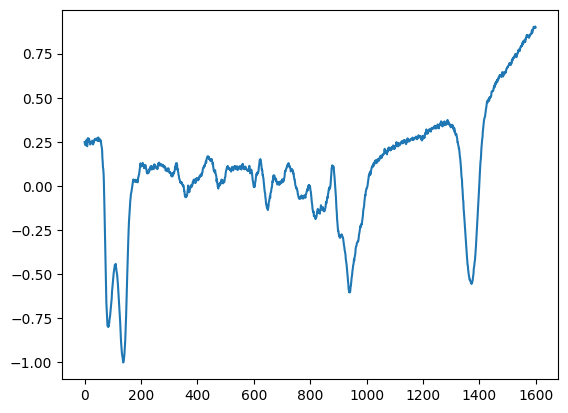

In [ ]:
plt.plot(np.dot(result.x, t_dataN_PCA) / np.max(np.dot(result.x, -1 * t_dataN_PCA)))
# plt.plot(normalized_spectra_wo_nan[-1])

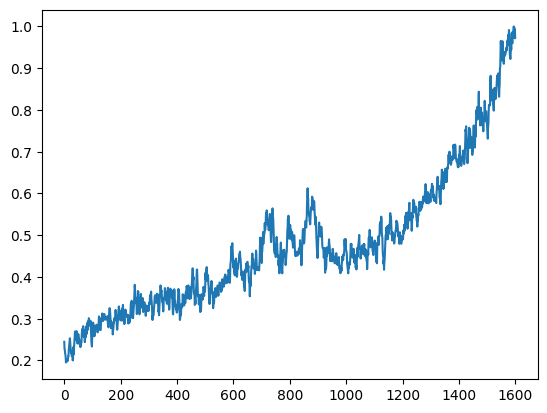

In [ ]:
plt.plot(normalized_spectra_wo_nan[-1])

In [ ]:
#Use minimize function
result_nmg = minimize(f3, [1, 1, 1, 1],args=(f_dataN_NMF, singals_wo_neg.T[-1] * 0.01), tol = 10**-12)

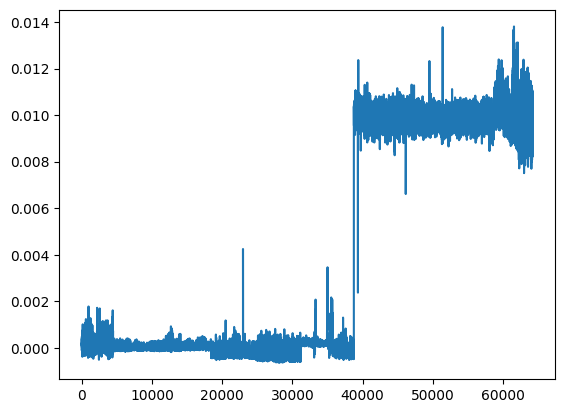

In [ ]:
# t_dataN_PCA.shape
plt.plot(np.dot(result_nmg.x, f_dataN_NMF.T))

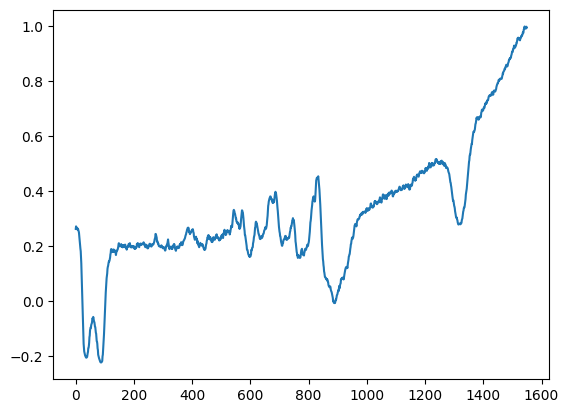

In [ ]:
plt.plot(np.dot(result.x, t_dataN_NMF) / np.max(np.dot(result.x, t_dataN_NMF)))
# plt.plot(normalized_spectra_wo_nan[-1])

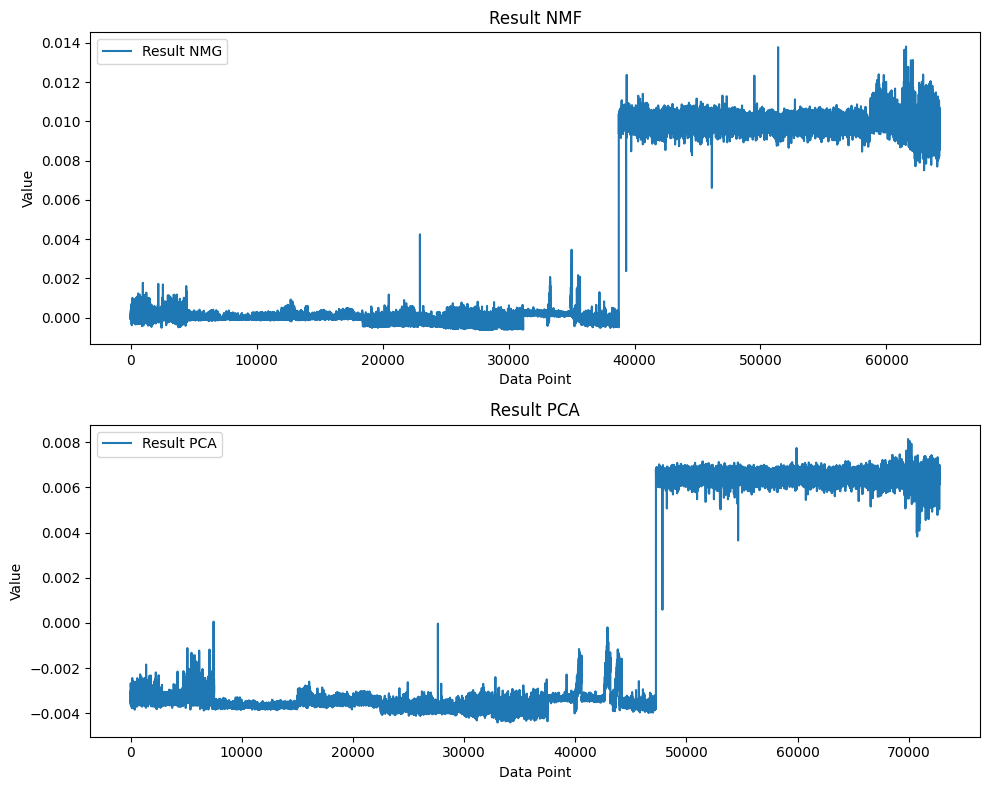

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot the first line on the first subplot
axes[0].plot(np.dot(result_nmg.x, f_dataN_NMF.T), label='Result NMG')

# Plot the second line on the second subplot
axes[1].plot(np.dot(result.x, f_dataN_PCA.T), label='Result PCA')

# Set titles and labels
axes[0].set_title('Result NMF')
axes[0].set_xlabel('Data Point')
axes[0].set_ylabel('Value')

axes[1].set_title('Result PCA')
axes[1].set_xlabel('Data Point')
axes[1].set_ylabel('Value')

# Add a legend to distinguish the two lines
axes[0].legend()
axes[1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

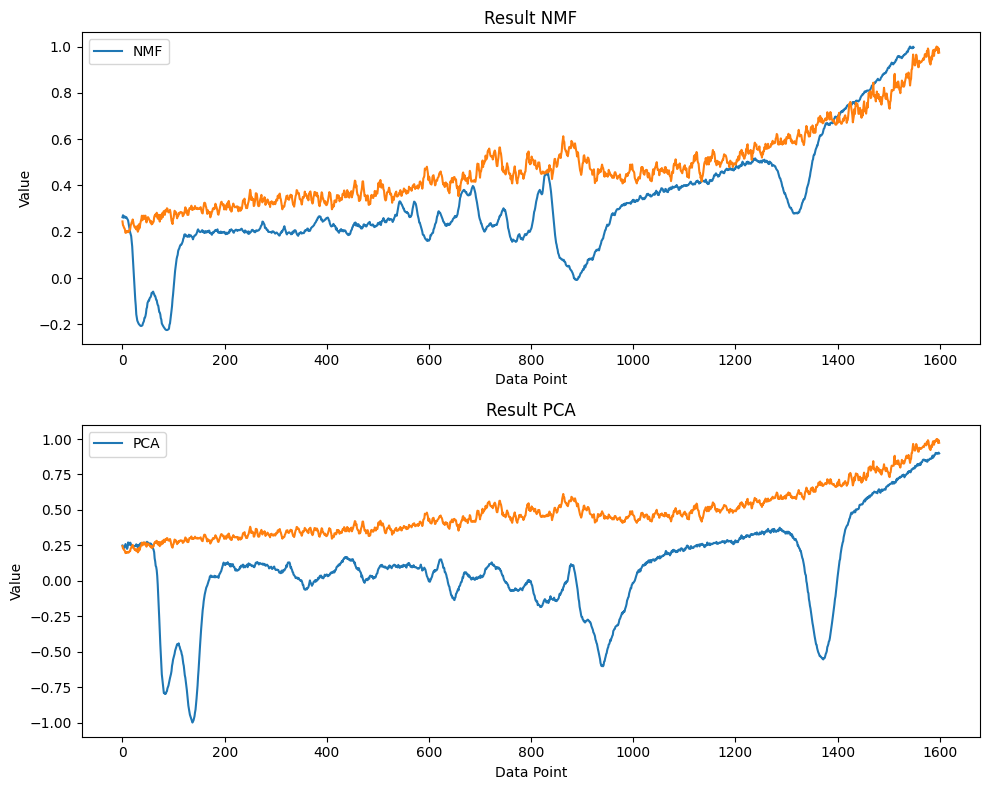

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].plot(np.dot(result.x, t_dataN_NMF) / np.max(np.dot(result.x, t_dataN_NMF)), label='NMF')
axes[0].plot(normalized_spectra_wo_negative[-1])

axes[1].plot(np.dot(result.x, t_dataN_PCA) / np.max(np.dot(result.x, -1 * t_dataN_PCA)), label='PCA')
axes[1].plot(normalized_spectra_wo_nan[-1])

# Set titles and labels
axes[0].set_title('Result NMF')
axes[0].set_xlabel('Data Point')
axes[0].set_ylabel('Value')

axes[1].set_title('Result PCA')
axes[1].set_xlabel('Data Point')
axes[1].set_ylabel('Value')

# Add a legend to distinguish the two lines
axes[0].legend()
axes[1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Generate synthetic multi-label dataset
X, y = make_multilabel_classification(n_samples=100, n_features=10, n_classes=5, random_state=42)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define class labels
class_labels = ["ant", "bird", "cat", "dolphin", "bee"]

In [ ]:
X.shape
print(y)

In [ ]:
# Create a multi-label classifier
classifier = MultiOutputClassifier(KNeighborsClassifier())

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

In [ ]:
hamming_loss(y_test, y_pred)

0.21

In [ ]:
# Calculate accuracy and Hamming loss
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)
confusion_matrices = multilabel_confusion_matrix(y_test, y_pred)
j_score = jaccard_score(y_test, y_pred, average='samples')

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)
print(f'Jaccard Score: {j_score}')

Accuracy: 0.3
Hamming Loss: 0.21
Jaccard Score: 0.6


In [ ]:
# Print confusion matrices for each label
for i in range(len(confusion_matrices)):
    print(f"Confusion Matrix for Label {i}:\n{confusion_matrices[i]}")

In [ ]:
# Visualize confusion matrices for each label
for i in range(len(confusion_matrices)):
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusion_matrices[i], annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"Confusion Matrix for {class_labels[i]}")
    plt.show()

In [ ]:
# Create a custom confusion matrix
unique_labels = np.unique(class_labels)
confusion_matrix = np.zeros((len(unique_labels) + 1, len(unique_labels) + 1), dtype=int)

for i, true_label in enumerate(y_test):
    for j, pred_label in enumerate(y_pred):
        for k, label in enumerate(unique_labels):
            if true_label[k] == 1 and pred_label[k] == 1:
                # True positive
                confusion_matrix[k, k] += 1
            elif true_label[k] == 1 and pred_label[k] == 0:
                # False negative
                confusion_matrix[k, -1] += 1
            elif true_label[k] == 0 and pred_label[k] == 1:
                # False positive
                confusion_matrix[-1, k] += 1

# Print the custom confusion matrix
print("Custom Confusion Matrix:")
print(confusion_matrix)

Custom Confusion Matrix:
[[ 20   0   0   0   0  60]
 [  0  90   0   0   0  90]
 [  0   0 117   0   0  63]
 [  0   0   0  63   0  77]
 [  0   0   0   0   6  54]
 [ 80 110 143 117  34   0]]


In [ ]:
# Plot the mean of the dataset that are 1 in the label mask
plt.plot(f_sup, np.mean(spectra_dataset_baselined[label_mask == 3], axis=0))

In [ ]:
# Plot all the spectra that are 1 in the label mask
plt.plot(spectra_dataset[label_mask == 1].T);

In [ ]:
# plt.plot(f_sup, spectra_dataset_sg[label_mask == 1].T);
plt.plot(f_sup, spectra_dataset_sg[0]);

### Baseline estimation

In [ ]:
# Baseline stimation with asymmetric least squares
# According to paper: "Baseline Correction with Asymmetric Least Squares Smoothing"
# by Paul H. C. Eilers and Hans F.M. Boelens. October 21, 2005

# We need the following packages here:
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Baseline stimation function:
def baseline_als(y, lam, p, niter=100):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [ ]:
def baseline_als(y, lam, p, niter=10):
  L = len(y)
  D = sparse.csc_matrix(np.diff(np.eye(L), 2))
  w = np.ones(L)
  for i in range(niter):
    W = sparse.spdiags(w, 0, L, L)
    Z = W + lam * D.dot(D.transpose())
    z = spsolve(Z, w*y)
    w = p * (y > z) + (1-p) * (y < z)
  return z

In [ ]:
sparse.diags([1,-2,1],[0,-1,-2], shape=(1600,1600-2))

<1600x1598 sparse matrix of type '<class 'numpy.float64'>'
	with 4794 stored elements (3 diagonals) in DIAgonal format>

In [ ]:
# Parameters for this case:
l = 10000000 # smoothness
p = 0.05 # asymmetry

In [ ]:
# Estimation of the baseline:
estimated_baselined = baseline_als(spectra_dataset[0], l, p)

# Baseline subtraction:
baselined_spectrum = spectra_dataset[0] - estimated_baselined

# How does it look like?
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

# We compared the original mix spectrum and the estimated baseline:
ax1.plot(f_sup, spectra_dataset[0], color = 'black', label = 'Mix spectrum with noise' )
ax1.plot(f_sup, estimated_baselined, color = 'red', label = 'Estimated baseline')
ax1.set_title('Baseline estimation', fontsize = 15)
ax1.set_xlabel('Wavelength', fontsize = 15)
ax1.set_ylabel('Intensity',  fontsize = 15)
ax1.legend()

# We plot the mix spectrum after baseline subtraction
ax2.plot(f_sup, baselined_spectrum, color = 'black', label = 'Baselined spectrum with noise' )
ax2.set_title('Baselined spectrum', fontsize = 15)
ax2.set_xlabel('Wavelength', fontsize = 15)
ax2.set_ylabel('Intensity',  fontsize = 15)
plt.show()

In [ ]:
estimated_baselined.shape

(1600,)

In [ ]:
# Estimate the baseline for all the spectra in the dataset using the function baseline_als
# Create a separate variable called spectra_dataset_baselined

spectra_dataset_baselined = np.zeros((73312, 1600))

In [ ]:
from joblib import Parallel, delayed
import multiprocessing

def compute_baseline(idx):
    if idx % 100 == 0:
        print("Processing spectrum", idx)
    return baseline_als(spectra_dataset[idx], l, p)

num_cores = multiprocessing.cpu_count()
spectra_dataset_baselined = Parallel(n_jobs=num_cores)(delayed(compute_baseline)(idx) for idx in range(len(spectra_dataset)))
spectra_dataset_baselined = spectra_dataset - np.array(spectra_dataset_baselined)

In [ ]:
# Plot the mean of the dataset that are 1 in the label mask from idx 300 till end
plt.plot(f_sup[300:], np.mean(spectra_dataset_baselined[0:7500, 300:], axis=0))

In [ ]:
# Plot all the spectra that are 1 in the label mask from index 200 till end
plt.plot(spectra_dataset_baselined[label_mask == 1][200:].T);

In [ ]:
scaler = StandardScaler()

In [ ]:
min_max_scaler = MinMaxScaler()

In [ ]:
scaled_dataset = np.zeros_like(spectra_dataset)

In [ ]:
# Fit the scaler to the dataset and transform the dataset where the label mask is 1
scaled_dataset[label_mask == 1] = scaler.fit_transform(spectra_dataset[label_mask == 1])

In [ ]:
# Fit the min_max_scaler to the dataset and transform the dataset where the label mask is 1
scaled_dataset[label_mask == 1] = min_max_scaler.fit_transform(spectra_dataset[label_mask == 1])

In [ ]:
plt.plot(f_sup, scaled_dataset[0])

In [ ]:
plt.plot(f_sup, spectra_dataset[0])

In [ ]:
plt.plot(f_sup, normalized_spectra[0])

## NMF

In [ ]:
n_components= 4
model = NMF(n_components)
W_NMF = model.fit_transform(normalized_spectra_wo_negative[:, 50:])
H_NMF = model.components_
t_dataN_NMF = H_NMF
f_dataN_NMF = W_NMF

## PCA

In [ ]:
n_components= 4
model = PCA(n_components)
W_PCA = model.fit_transform(normalized_spectra_wo_nan)
H_PCA = model.components_
t_dataN_PCA = H_PCA
f_dataN_PCA = W_PCA

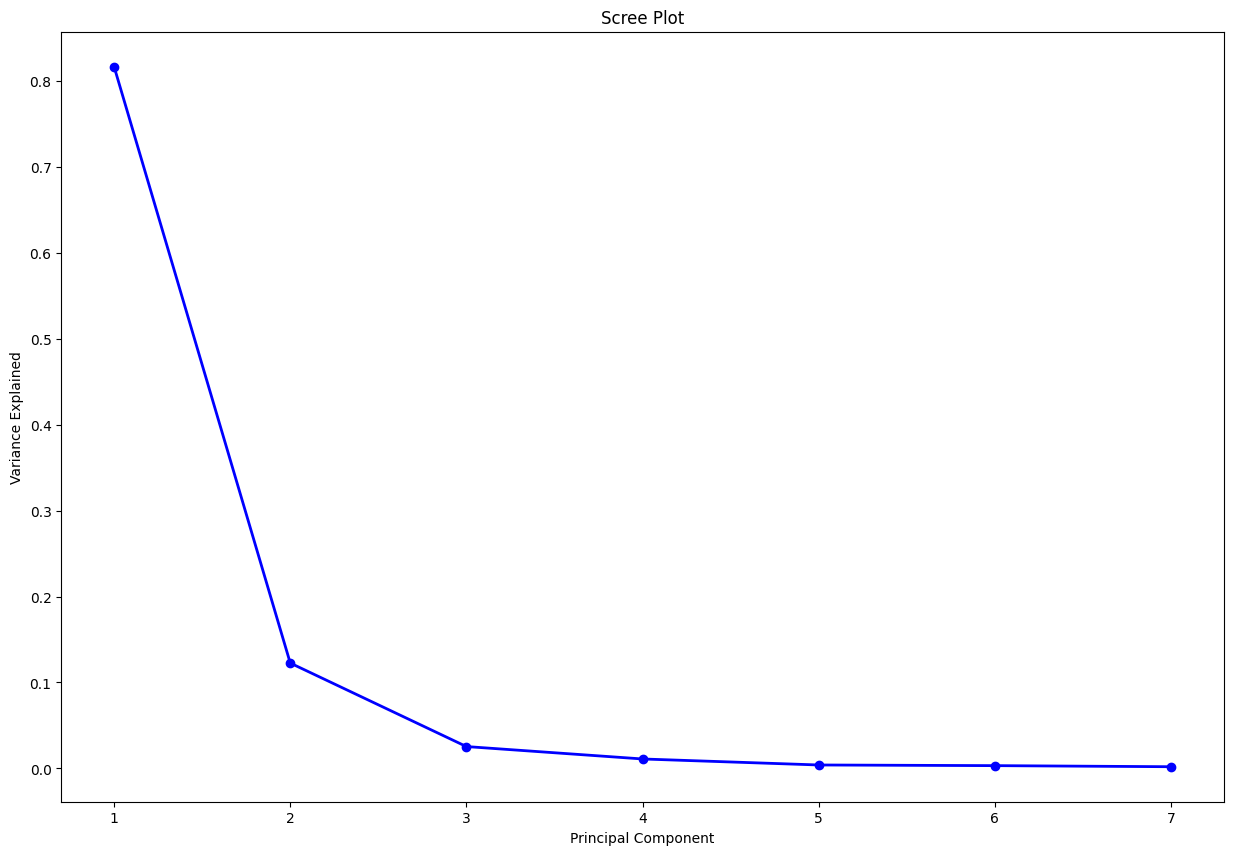

In [ ]:
PC_values = np.arange(model.n_components_) + 1
plt.figure(figsize=(15,10))
plt.plot(PC_values, model.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

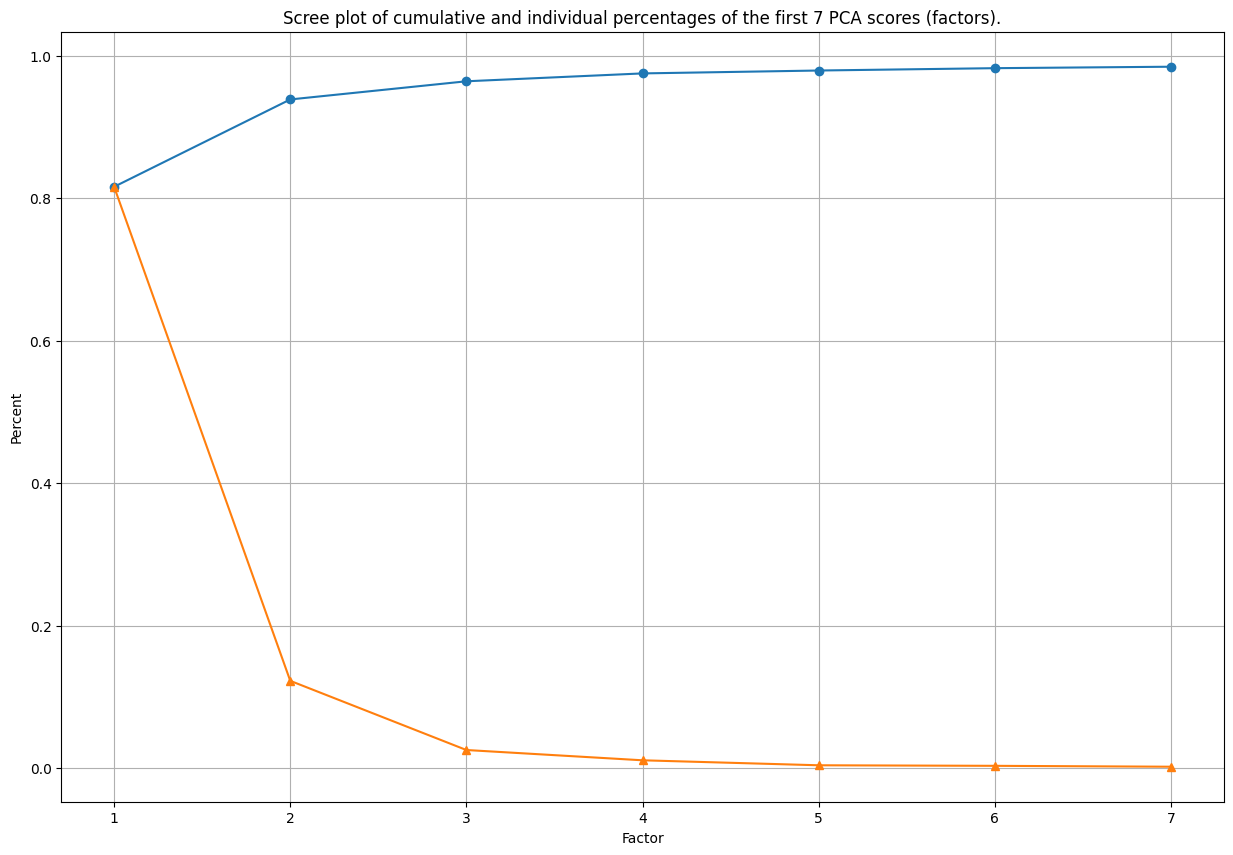

In [ ]:
explained_variance_ratio = model.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot individual explained variance
plt.figure(figsize=(15, 10))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='-', label='Cumulative percent')
plt.plot(range(1, n_components + 1), explained_variance_ratio, marker='^', linestyle='-', label='Individual percent')
plt.xlabel('Factor')
plt.ylabel('Percent')
plt.title('Scree plot of cumulative and individual percentages of the first 7 PCA scores (factors).')
plt.grid()
plt.show()

In [ ]:
scree_data = np.column_stack((np.arange(1, n_components + 1), explained_variance_ratio, cumulative_explained_variance))

np.savetxt('pca_explained_variance.csv', scree_data, delimiter=',', header='Range,Explained Variance Ratio,Cumulative Explained Variance', comments='')

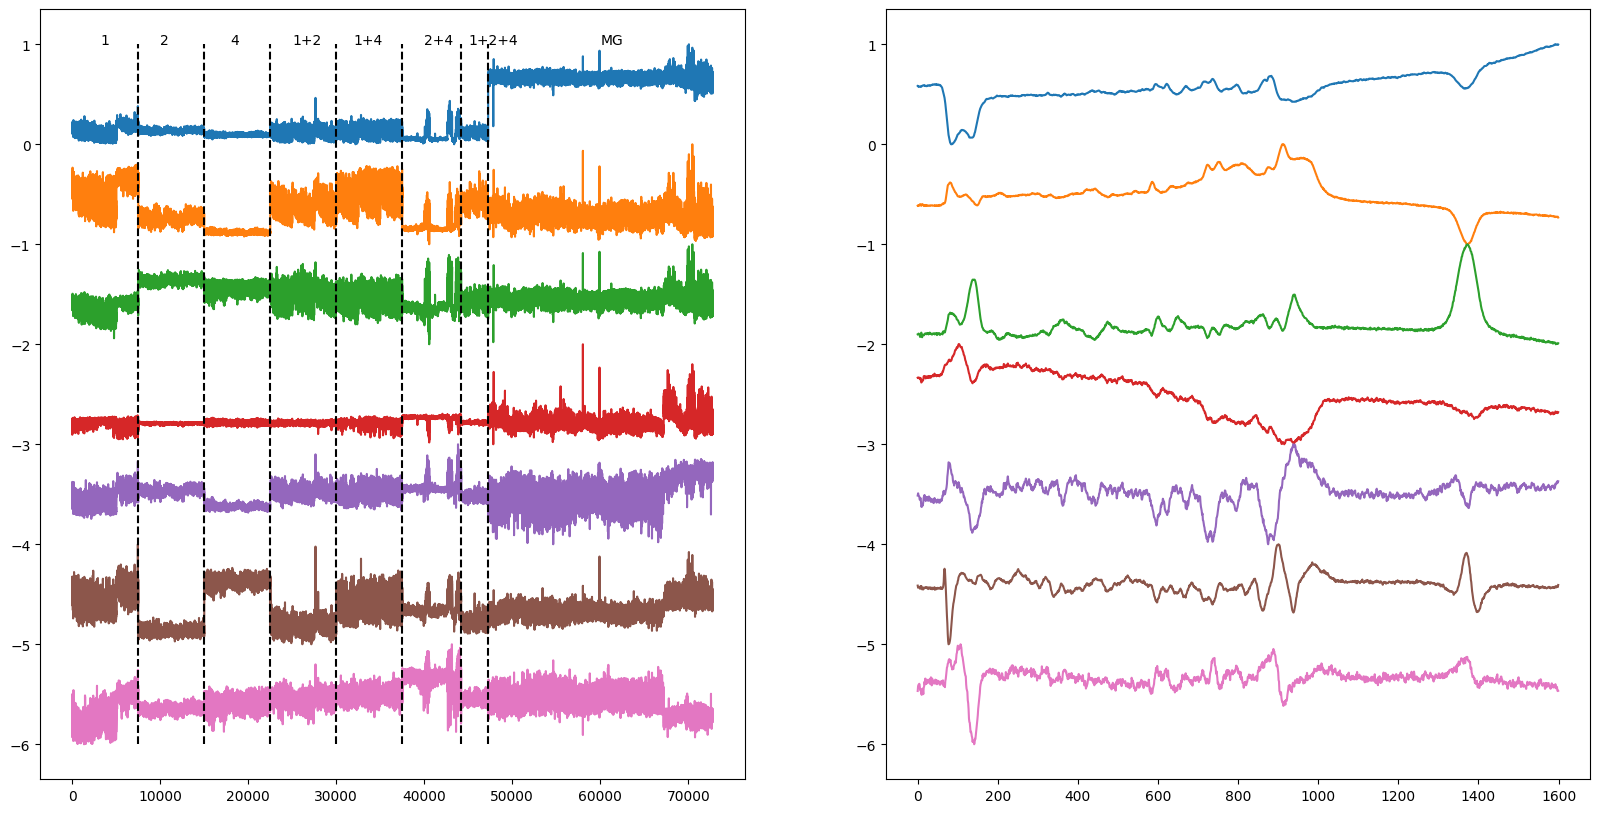

In [ ]:
# Plot the first subplot
plt.figure(figsize = (20, 10))
plt.subplot(121)
for i in range(n_components):
    # Normalize and plot each column of f_dataN_PCA
    plt.plot((f_dataN_PCA[:,i]-min(f_dataN_PCA[:,i]))/np.mean(max(f_dataN_PCA[:,i])-min(f_dataN_PCA[:,i]))-i)

# Add vertical lines and text labels
plt.vlines(x=[7500, 15000, 22500, 30000, 37500, 44188, 47260], ymin=-6, ymax=1, colors="k", linestyles="dashed")
plt.text(3250,1,"1")
plt.text(10000,1,"2")
plt.text(18000,1,"4")
plt.text(25000,1,"1+2")
plt.text(32000,1,"1+4")
plt.text(40000,1,"2+4")
plt.text(45000,1,"1+2+4")
plt.text(60000,1,"MG")

# Plot the second subplot
plt.subplot(122)
for i in range(n_components):
    # Normalize and plot each row of t_dataN_PCA
    plt.plot(((t_dataN_PCA[i]-min(t_dataN_PCA[i]))/(max(t_dataN_PCA[i])-min(t_dataN_PCA[i]))-i))

plt.show()

## KNN

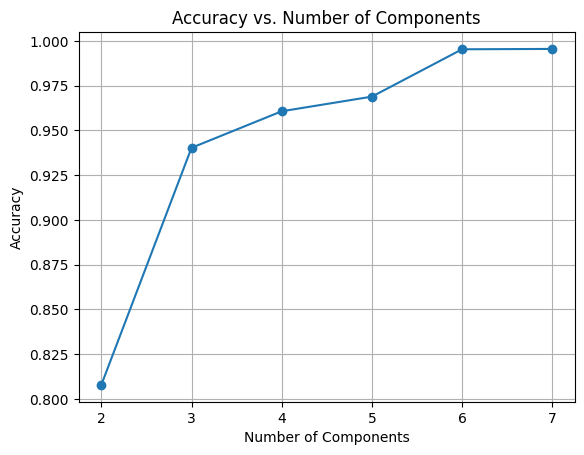

In [ ]:
# Assuming your dataset is stored in a numpy array called 'data' and the corresponding labels are stored in 'labels'

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Define the range of components to test
components_range = range(2, 8)

# Initialize a list to store the accuracy results
accuracy_results = []

for n_components in components_range:
    # Perform PCA on the training set with the current number of components
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)

    # Fit a KNN classifier on the transformed training set
    knn = KNeighborsClassifier(n_neighbors=n_components)
    knn.fit(X_train_pca, y_train)

    # Transform the testing set using the same PCA object
    X_test_pca = pca.transform(X_test)

    # Predict the labels of the testing set using the trained KNN classifier
    y_pred = knn.predict(X_test_pca)

    # Calculate and store the accuracy for this number of components
    accuracy = np.mean(y_pred == y_test)
    accuracy_results.append(accuracy)

# Plot the accuracy results
plt.plot(components_range, accuracy_results, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.xticks(components_range)
plt.grid(True)
plt.show()

In [ ]:
accuracy_table = []
accuracy_table.append(accuracy_results)

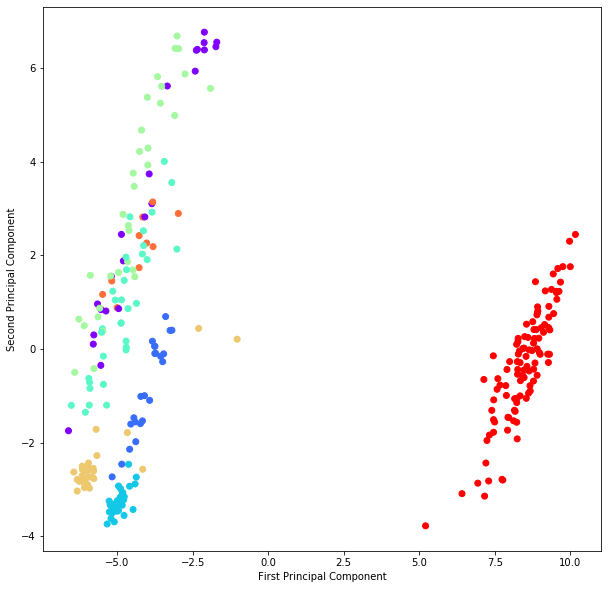

In [ ]:
# Create a scatter plot with every 200th point
plt.figure(figsize=(10, 10))
plt.scatter(X_train_pca[::200, 0], X_train_pca[::200, 1], c=y_train[::200], cmap='rainbow')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [ ]:
def scatter_plot_with_subset(X, y, num_points):
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 20))
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    # Define the combinations of principal components
    combinations = [(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3)]

    labels = ["Car", "Thia", "Aceta", "Car+Thia", "Car+Aceta", "Thia+Aceta", "Car+Thia+Aceta", "MG"]

    for i, (pc1, pc2) in enumerate(combinations):
        row, col = i // 3, i % 3
        ax = axes[row, col]

        # Scatter plot with every num_points
        sc = ax.scatter(X[::num_points, pc1], X[::num_points, pc2], c=y[::num_points], cmap='rainbow')
        ax.set_xlabel(f'Principal Component {pc1 + 1}')
        ax.set_ylabel(f'Principal Component {pc2 + 1}')

        # Add a legend with labels
        handles, _ = sc.legend_elements(num=len(labels))
        ax.legend(handles, labels, title="Classes")

    plt.show()

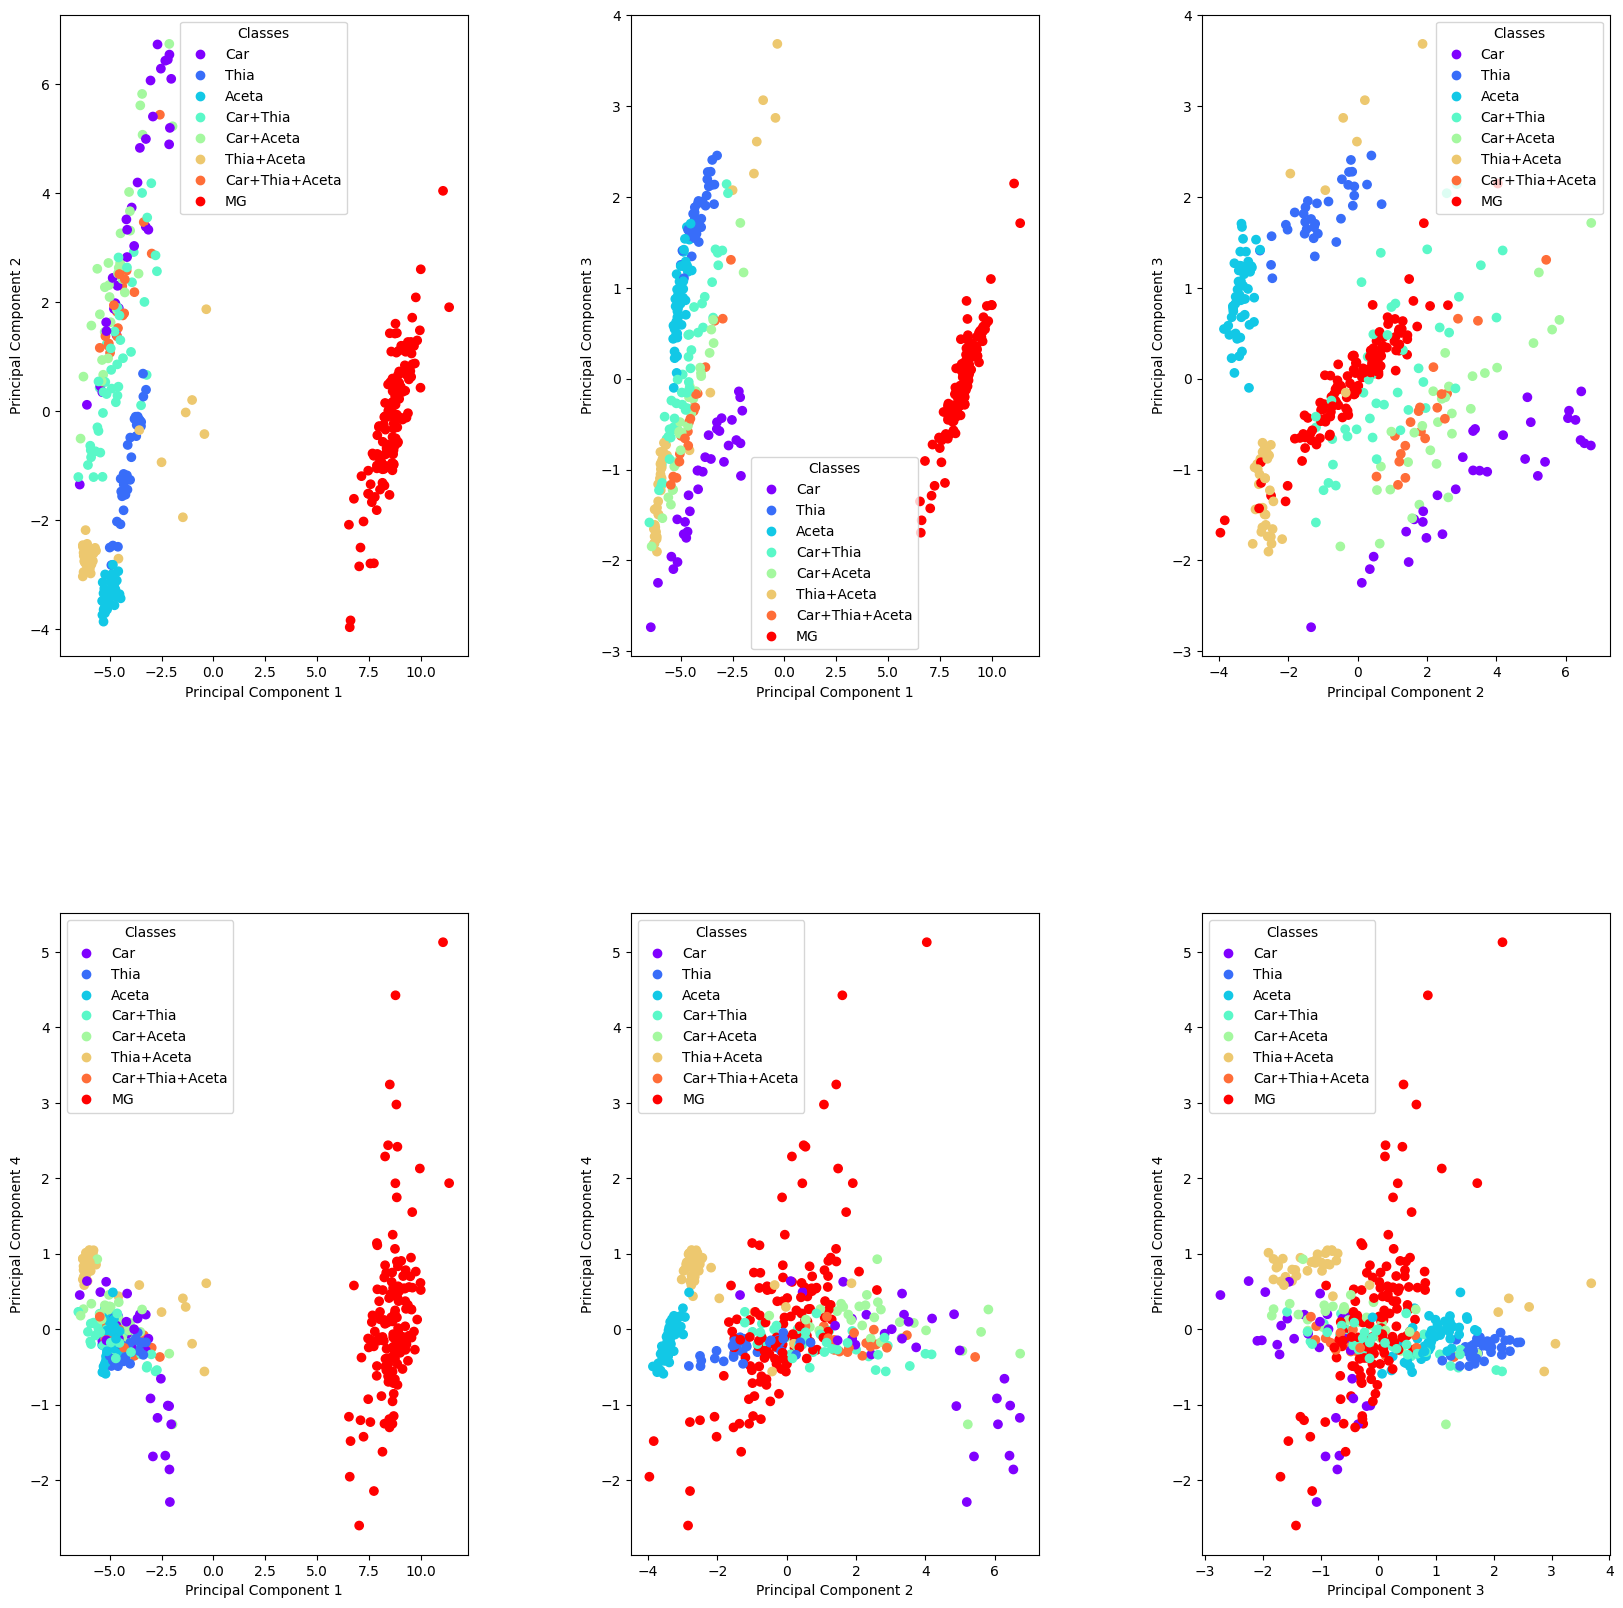

In [ ]:
# Call the function with the desired number of points
scatter_plot_with_subset(X_train_pca, y_train, num_points=150)

In [ ]:
X_train_pca.shape[0] / 150

388.1666666666667

In [ ]:
step = 150

# Create a file to save your CSV data
file_path = 'pca_results.csv'

# Choose every 150 points and transpose the data for column-wise storage
selected_data = X_train_pca[::step, :]
selected_labels = y_train[::step]

In [ ]:
selected_labels.shape
selected_data.shape

(389, 7)

In [ ]:
np.savetxt(file_path, np.column_stack((selected_data, selected_labels)), delimiter=',', fmt='%f', header="PC1, PC2, PC3, PC4, PC5, PC6, PC7, Labels")

In [ ]:
from sklearn.metrics import confusion_matrix

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Define the range of components to test
components_range = range(2, 8)

# Initialize lists to store accuracy and confusion matrix results
accuracy_results = []
confusion_matrix_results = []

for n_components in components_range:
    # Perform PCA on the training set with the current number of components
    pca = PCA(n_components=n_components)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)

    # Fit a KNN classifier on the transformed training set
    knn = KNeighborsClassifier(n_neighbors=n_components)
    knn.fit(X_train_pca, y_train)

    # Transform the testing set using the same PCA object
    X_test_pca = pca.transform(X_test)

    # Predict the labels of the testing set using the trained KNN classifier
    y_pred = knn.predict(X_test_pca)

    # Calculate and store the accuracy for this number of components
    accuracy = np.mean(y_pred == y_test)
    accuracy_results.append(accuracy)

    # Calculate and store the confusion matrix for this number of components
    confusion_matrix_results.append(confusion_matrix(y_test, y_pred))

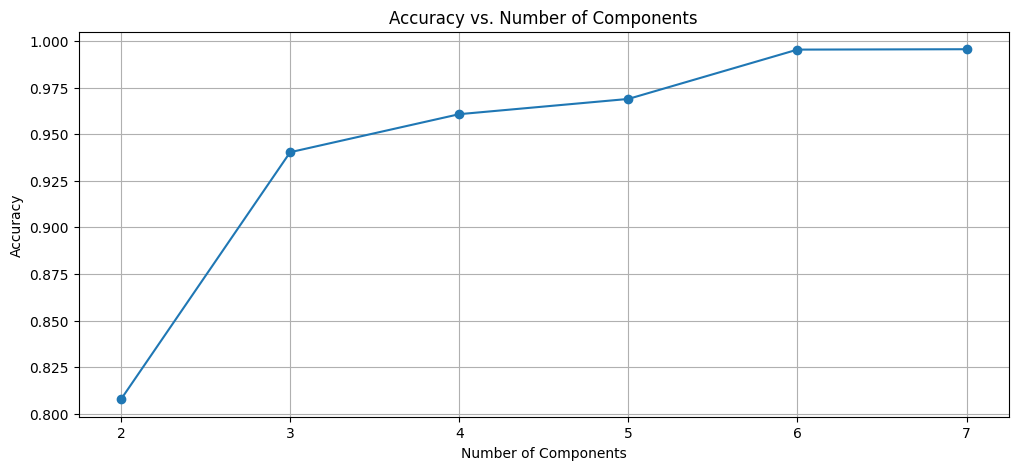

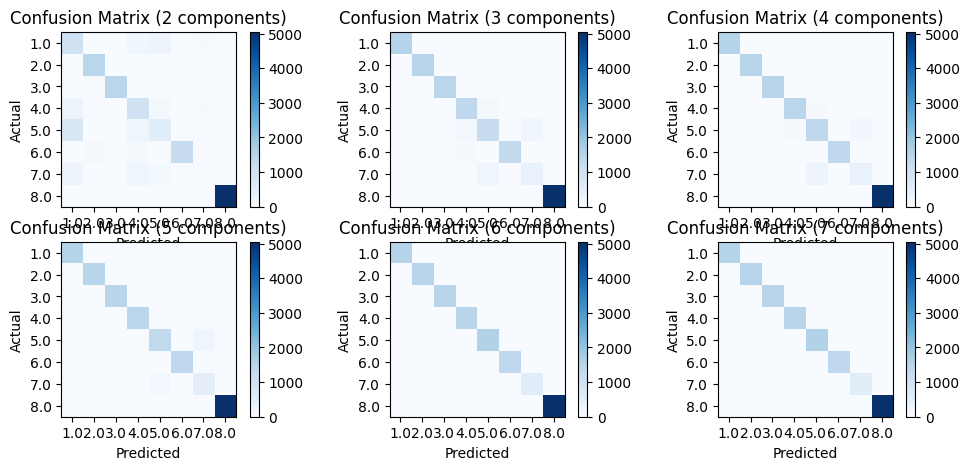

In [ ]:
# Plot the accuracy results
plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
plt.plot(components_range, accuracy_results, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.xticks(components_range)
plt.grid(True)
plt.show()

# Plot confusion matrices (one for each number of components)
plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 2)
for i, n_components in enumerate(components_range):
    plt.subplot(2, 3, i + 1)
    plt.imshow(confusion_matrix_results[i], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({n_components} components)')
    plt.colorbar()
    plt.xticks(np.arange(len(np.unique(y_test))), np.unique(y_test))
    plt.yticks(np.arange(len(np.unique(y_test))), np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

# plt.tight_layout()
plt.show()

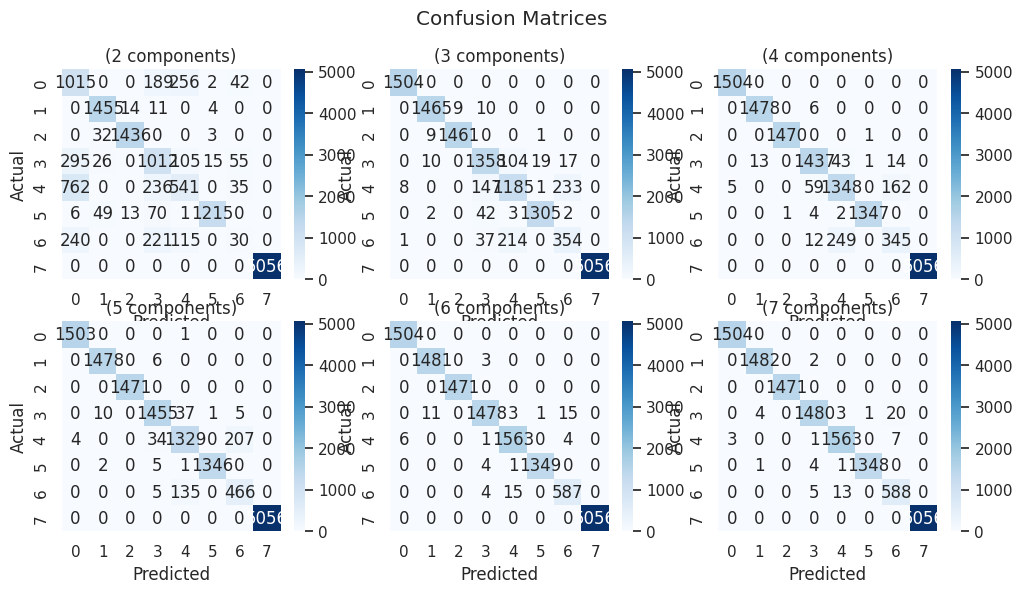

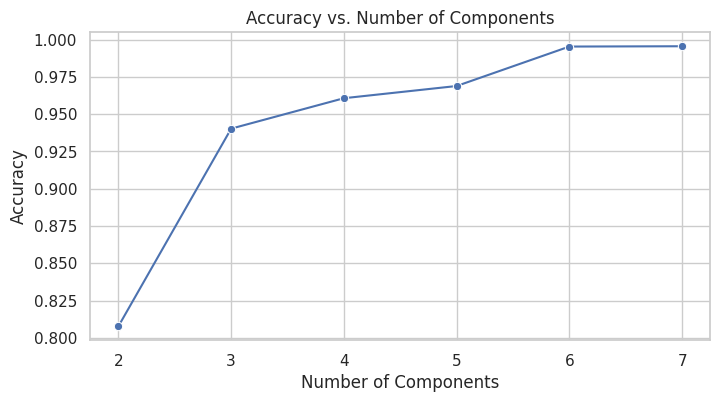

In [ ]:
# Select every 150 points from the dataset
selected_indices = range(0, len(normalized_spectra_wo_nan), 150)
selected_data = normalized_spectra_wo_nan[selected_indices]
selected_labels = label_mask_wo_nan[selected_indices]

# Set Seaborn style
sns.set(style="whitegrid")

# Create a grid of subplots for confusion matrices
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle('Confusion Matrices')

for i, n_components in enumerate(components_range):
    ax = axes[i // 3, i % 3]
    sns.heatmap(confusion_matrix_results[i], annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f'({n_components} components)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

# Separate figure for the accuracy plot
plt.figure(figsize=(8, 4))
sns.lineplot(x=components_range, y=accuracy_results, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.xticks(components_range)
plt.grid(True)

plt.show()

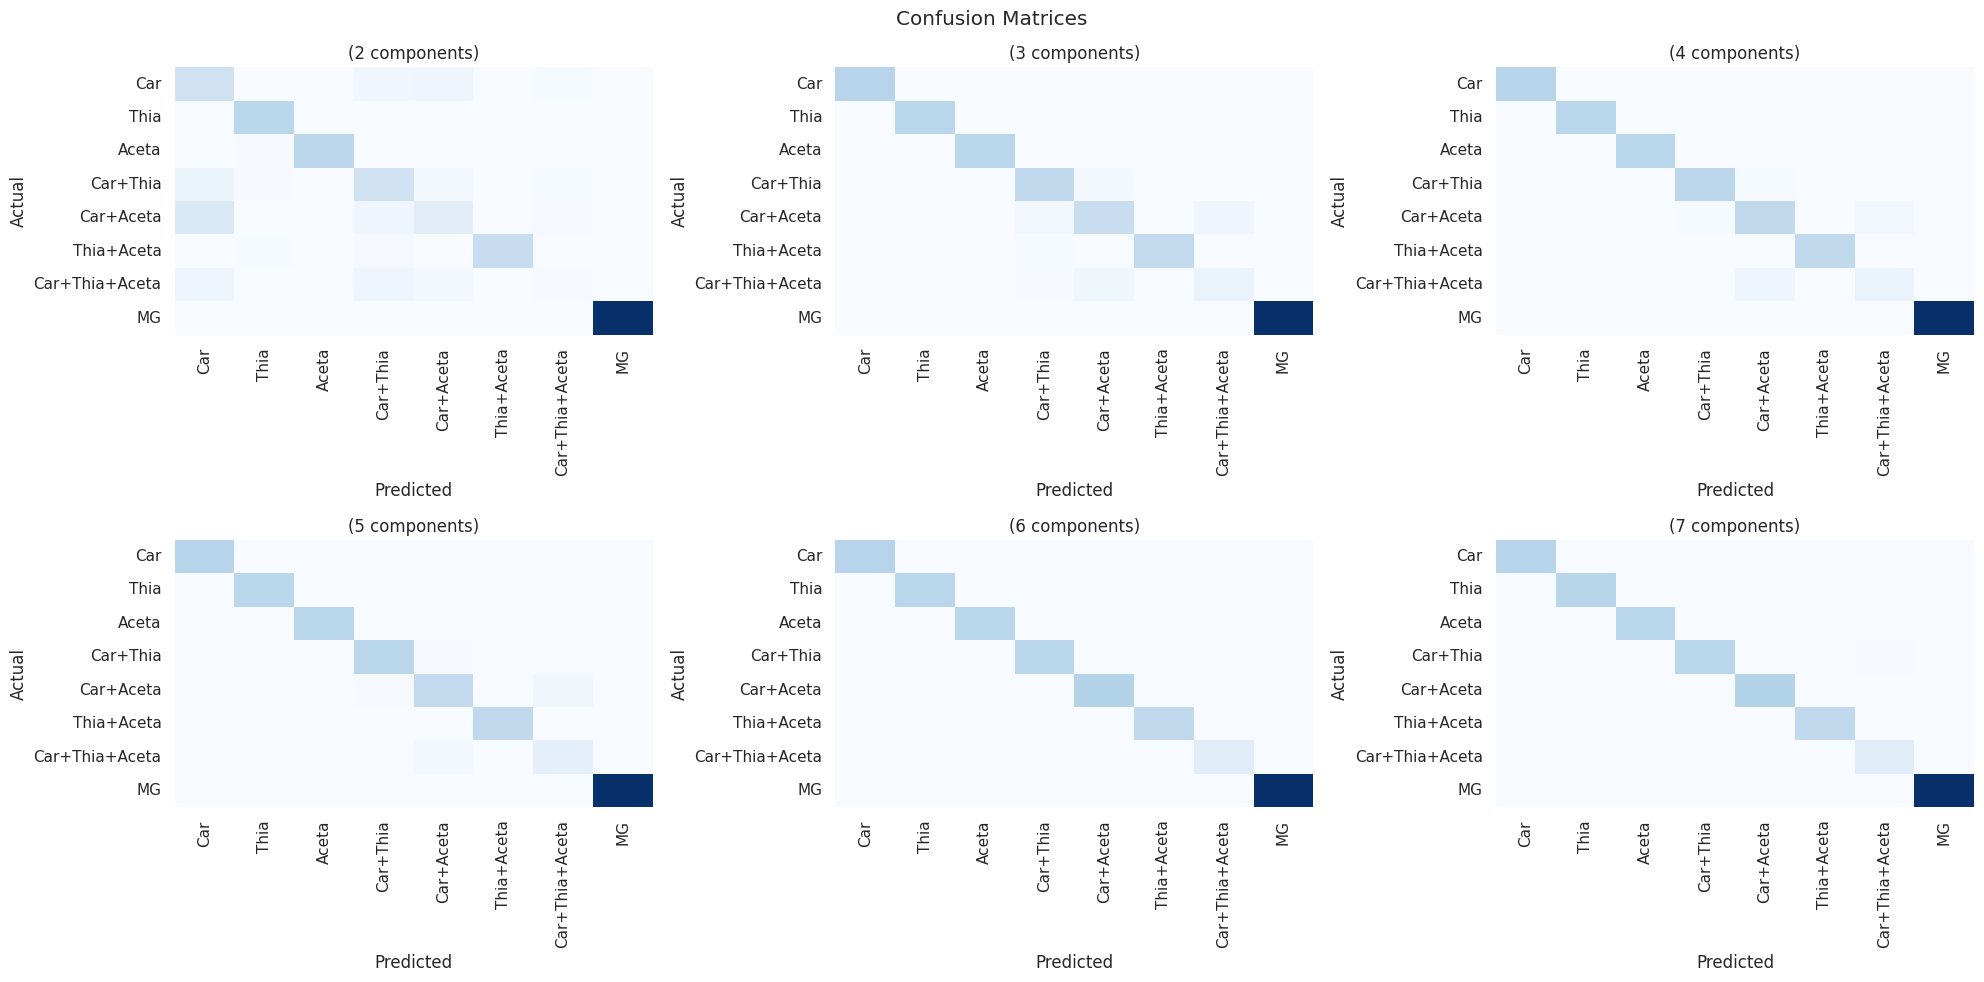

In [ ]:
# Set Seaborn style
sns.set(style="whitegrid")
labels = ["Car", "Thia", "Aceta", "Car+Thia", "Car+Aceta", "Thia+Aceta", "Car+Thia+Aceta", "MG"]

# Create a grid of subplots for confusion matrices with more space
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Confusion Matrices')

for i, n_components in enumerate(components_range):
    ax = axes[i // 3, i % 3]

    # Create a confusion matrix heatmap with class labels
    sns.heatmap(confusion_matrix_results[i], annot=False, cmap="Blues", ax=ax, cbar=False, xticklabels=labels, yticklabels=labels)

    ax.set_title(f'({n_components} components)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # Rotate class labels perpendicularly to the box
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## SVM

In [ ]:
# Step 1: Data Preprocessing - Import data and labels

# Step 2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Step 3: Feature Selection or Dimensionality Reduction (if needed)

# Step 4: Model Selection - Choose the SVM model
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # Example with an RBF kernel

# Step 5: Model Training
svm_model.fit(X_train, y_train)

# Step 6: Model Evaluation
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.999793913581095


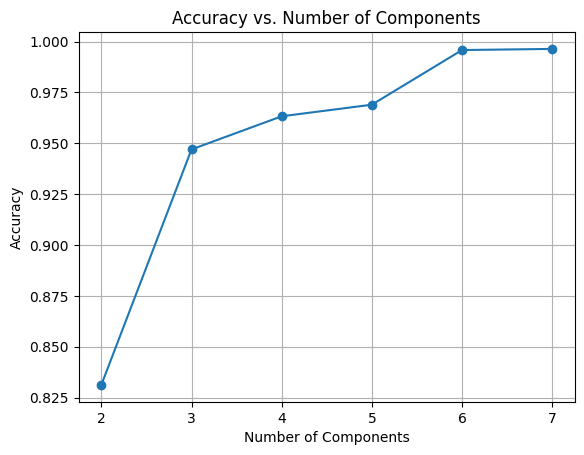

In [ ]:
# Step 1: Data Preprocessing - Import data and labels

# Step 2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Initialize an empty list to store accuracy values
accuracy_values = []

# Step 6: Model Evaluation
for n_components in range(2, 8):
    # Step 3: PCA for Dimensionality Reduction
    pca = PCA(n_components=n_components)

    # Step 4: SVM Model Selection
    svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')  # Example with an RBF kernel

    # Step 5: Create a Pipeline
    # Combine PCA and SVM into a single pipeline
    model = Pipeline([('pca', pca), ('svm', svm_model)])

    # Step 7: Model Training
    model.fit(X_train, y_train)

    # Step 6: Model Evaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Append the accuracy to the list
    accuracy_values.append(accuracy)

# Step 8: Hyperparameter Tuning (if needed)

# Step 9: Model Deployment
# You can now use the trained model with the optimal number of components to make predictions on new data.

# Step 10: Plot the accuracy values
components_range = list(range(2, 8))
plt.plot(components_range, accuracy_values, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:
accuracy_table.append(accuracy_values)

## Naive Bayes

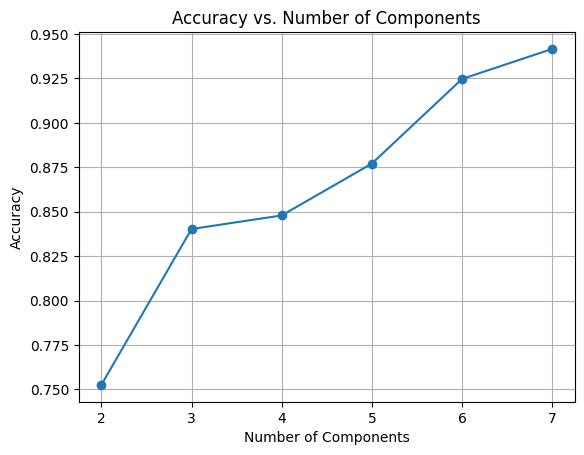

In [ ]:
# Step 1: Data Preprocessing - Import data and labels

# Step 2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Initialize an empty list to store accuracy values
accuracy_values = []

# Step 6: Model Evaluation
for n_components in range(2, 8):
    # Step 3: PCA for Dimensionality Reduction
    pca = PCA(n_components=n_components)

    # Step 4: Naive Bayes Model Selection (Gaussian Naive Bayes)
    nb_model = GaussianNB()

    # Step 5: Create a Pipeline
    # Combine PCA and Naive Bayes into a single pipeline
    model = Pipeline([('pca', pca), ('nb', nb_model)])

    # Step 7: Model Training
    model.fit(X_train, y_train)

    # Step 6: Model Evaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Append the accuracy to the list
    accuracy_values.append(accuracy)

# Step 8: Hyperparameter Tuning (if needed)

# Step 9: Model Deployment
# You can now use the trained model with the optimal number of components to make predictions on new data.

# Step 10: Plot the accuracy values
components_range = list(range(2, 8))
plt.plot(components_range, accuracy_values, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:
accuracy_table.append(accuracy_values)

## Random Forest

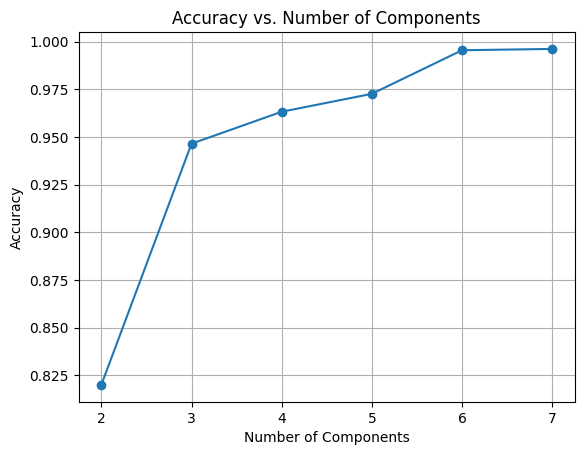

In [ ]:
# Step 1: Data Preprocessing - Import data and labels

# Step 2: Data Splitting
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

# Initialize an empty list to store accuracy values
accuracy_values = []

# Step 6: Model Evaluation
for n_components in range(2, 8):
    # Step 3: PCA for Dimensionality Reduction
    pca = PCA(n_components=n_components)

    # Step 4: Random Forest Model Selection
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Step 7: Model Training
    # Apply PCA and then train the Random Forest model
    X_train_pca = pca.fit_transform(X_train)
    rf_model.fit(X_train_pca, y_train)

    # Step 6: Model Evaluation
    X_test_pca = pca.transform(X_test)
    y_pred = rf_model.predict(X_test_pca)
    accuracy = accuracy_score(y_test, y_pred)

    # Append the accuracy to the list
    accuracy_values.append(accuracy)

# Step 8: Hyperparameter Tuning (if needed)

# Step 9: Model Deployment
# You can now use the trained model with the optimal number of components to make predictions on new data.

# Step 10: Plot the accuracy values
components_range = list(range(2, 8))
plt.plot(components_range, accuracy_values, marker='o')
plt.title('Accuracy vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:
accuracy_table.append(accuracy_values)

In [ ]:
import csv
import copy

In [ ]:
def take_two_digits_after_decimal_point_without_rounding(number):
    """Takes two digits after the decimal point without rounding.

    Args:
      number: A float number.

    Returns:
      A float number with two digits after the decimal point.
    """

    string_representation = str(number)
    decimal_point_index = string_representation.find('.')
    two_digits_after_decimal_point = string_representation[decimal_point_index + 1:decimal_point_index + 3]
    return float(two_digits_after_decimal_point)

In [ ]:
def take_two_digits_after_decimal_point_without_rounding_list_of_lists(list_of_lists):
  """Takes two digits after the decimal point without rounding for a list of lists.

  Args:
    list_of_lists: A list of lists containing float numbers.

  Returns:
    A list of lists with two digits after the decimal point for each element.
  """

  for i in range(len(list_of_lists)):
    for j in range(len(list_of_lists[i])):
      list_of_lists[i][j] = take_two_digits_after_decimal_point_without_rounding(list_of_lists[i][j])
  return list_of_lists

In [ ]:
copied_accuracy_table = copy.deepcopy(accuracy_table)
new_list_of_lists = take_two_digits_after_decimal_point_without_rounding_list_of_lists(copied_accuracy_table)

In [ ]:
rounded_acc_values = np.around(accuracy_table, 2)

In [ ]:
decimal_acc_values = [[x * 100 for x in y] for y in new_list_of_lists]

In [ ]:
new_list_of_lists

[[80.0, 94.0, 96.0, 96.0, 99.0, 99.0],
 [83.0, 94.0, 96.0, 96.0, 99.0, 99.0],
 [75.0, 84.0, 84.0, 87.0, 92.0, 94.0],
 [81.0, 94.0, 96.0, 97.0, 99.0, 99.0]]

In [ ]:
with open('accuracy_table_rounded_decimal.csv', 'w', newline='') as csvfile:
    # Create a CSV writer object
    writer = csv.writer(csvfile)

    # Write the sublists to the CSV file using the writerow() method
    for row in new_list_of_lists:
        writer.writerow(row)

# Close the CSV file
csvfile.close()

## Multilabel multioutput classification

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(normalized_spectra_wo_nan, label_mask_wo_nan, test_size=0.2, random_state=42)

In [ ]:
# Define class labels
class_labels = ["Carbendazim", "Thiacloprid", "Acetamiprid", "MG"]

In [ ]:
# Create a multi-label classifier
classifier = MultiOutputClassifier(KNeighborsClassifier())

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

In [ ]:
csv_file_path = "y_pred.csv"

# Save y_pred to a CSV file
np.savetxt(csv_file_path, y_pred, delimiter=",")

In [ ]:
y_pred_loaded = np.genfromtxt("y_pred.csv", delimiter=',')

In [ ]:
y_pred = np.copy(y_pred_loaded)

In [ ]:
# Calculate accuracy and Hamming loss
accuracy = accuracy_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)
confusion_matrices = multilabel_confusion_matrix(y_test, y_pred)
j_score = jaccard_score(y_test, y_pred, average='samples')

print("Accuracy:", accuracy)
print("Hamming Loss:", hamming_loss_value)
print(f'Jaccard Score: {j_score}')

Accuracy: 0.9984200041217284
Hamming Loss: 0.0004636944425362369
Jaccard Score: 0.9993244945158115


In [ ]:
# Create a custom confusion matrix
unique_labels = np.unique(class_labels)
confusion_matrix = np.zeros((len(unique_labels) + 1, len(unique_labels) + 1), dtype=int)

for i, true_label in enumerate(y_test):
    for j, pred_label in enumerate(y_pred):
        for k, label in enumerate(unique_labels):
            if true_label[k] == 1 and pred_label[k] == 1:
                # True positive
                confusion_matrix[k, k] += 1
            elif true_label[k] == 1 and pred_label[k] == 0:
                # False negative
                confusion_matrix[k, -1] += 1
            elif true_label[k] == 0 and pred_label[k] == 1:
                # False positive
                confusion_matrix[-1, k] += 1

# Print the custom confusion matrix
print("Custom Confusion Matrix:")
print(confusion_matrix)

Custom Confusion Matrix:
[[26962056        0        0        0 48617888]
 [       0 24561920        0        0 47524344]
 [       0        0 25030005        0 47827780]
 [       0        0        0 25563136 48037056]
 [48632445 47640800 47769552 48037056        0]]


## Deep Learning

In [ ]:
device = torch.device("cuda")

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler

In [ ]:
dataset_tensor = torch.tensor(normalized_spectra_wo_nan, dtype=torch.long)
labels_tensor = torch.tensor(label_mask_wo_nan, dtype=torch.long)

In [ ]:
# Determine the sizes of your train, validation, and test sets
train_size = 0.6
val_size = 0.2
test_size = 0.2

# Define number of workers for GPU
num_workers = 2

# Step 1: Split the dataset into train and temp sets
data_train, data_temp, labels_train, labels_temp = train_test_split(dataset_tensor, labels_tensor, test_size=(1 - train_size))

# Step 2: Split the temp set into validation and test sets
data_val, data_test, labels_val, labels_test = train_test_split(data_temp, labels_temp, test_size=test_size / (test_size + val_size))

# Step 3: Create datasets and data loaders
train_dataset = TensorDataset(data_train, labels_train)
val_dataset = TensorDataset(data_val, labels_val)
test_dataset = TensorDataset(data_test, labels_test)

# Define data loaders for train, validation, and test sets
batch_size = 256  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
class ModelC2(torch.nn.Module):
    def __init__(self):
        super(ModelC2, self).__init__()

        self.dense1 = torch.nn.Linear(1600, 8)
        self.dense2 = torch.nn.Linear(8, 8)
        self.dense3 = torch.nn.Linear(8, 10)
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = self.softmax(self.dense3(x))
        return x

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, encoder_outputs):
        energy = torch.tanh(self.attn(encoder_outputs))
        attention = torch.nn.functional.softmax(self.v(energy), dim=0)
        context = torch.sum(attention * encoder_outputs, dim=0)
        return context

class ModelC2WithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ModelC2WithAttention, self).__init__()
        self.dense1 = torch.nn.Linear(input_dim, hidden_dim)
        self.dense2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = torch.nn.Linear(hidden_dim, output_dim)
        self.softmax = torch.nn.Softmax(dim=1)
        self.attention = Attention(hidden_dim)

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = self.dense3(x)
        x = self.softmax(x)

        # Apply attention mechanism to the output of dense3
        context = self.attention(x)

        return context


In [ ]:
# Initialize your model
model = ModelC2()
model = model.to(device)  # Moves the model to GPU

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 100

# Initialize lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

In [ ]:
model_with_attention = ModelC2WithAttention(input_dim=1600, hidden_dim=16, output_dim=8)

In [ ]:
# Check if the model is on the GPU
if next(model.parameters()).is_cuda:
    print("Model is on GPU")
else:
    print("Model is on CPU")

# # Check if your tensors are on the GPU (e.g., inputs and labels)
# if inputs.is_cuda:
#     print("Inputs are on GPU")
# else:
#     print("Inputs are on CPU")

# if labels.is_cuda:
#     print("Labels are on GPU")
# else:
#     print("Labels are on CPU")

Model is on GPU


In [ ]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate metrics for the epoch
    train_losses.append(loss.item())
    val_losses.append(val_loss / len(val_loader))
    val_accuracy = (100 * correct / total)
    val_accuracies.append(val_accuracy)


    # Print the training and validation statistics for the epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {loss.item():.4f} - Validation Loss: {val_loss/len(val_loader):.4f} - Validation Accuracy: {(100 * correct / total):.2f}%")

print("Training finished.")

Epoch 1/100 - Training Loss: 2.2700 - Validation Loss: 2.2680 - Validation Accuracy: 34.42%
Epoch 2/100 - Training Loss: 2.0084 - Validation Loss: 1.9948 - Validation Accuracy: 42.99%
Epoch 3/100 - Training Loss: 1.9679 - Validation Loss: 1.9525 - Validation Accuracy: 48.96%
Epoch 4/100 - Training Loss: 1.8987 - Validation Loss: 1.8860 - Validation Accuracy: 57.93%
Epoch 5/100 - Training Loss: 1.8867 - Validation Loss: 1.8717 - Validation Accuracy: 57.90%
Epoch 6/100 - Training Loss: 1.8777 - Validation Loss: 1.8622 - Validation Accuracy: 61.66%
Epoch 7/100 - Training Loss: 1.8641 - Validation Loss: 1.8477 - Validation Accuracy: 61.64%
Epoch 8/100 - Training Loss: 1.8626 - Validation Loss: 1.8414 - Validation Accuracy: 61.64%
Epoch 9/100 - Training Loss: 1.8619 - Validation Loss: 1.8393 - Validation Accuracy: 61.70%
Epoch 10/100 - Training Loss: 1.8549 - Validation Loss: 1.8379 - Validation Accuracy: 61.82%
Epoch 11/100 - Training Loss: 1.8591 - Validation Loss: 1.8374 - Validation Acc

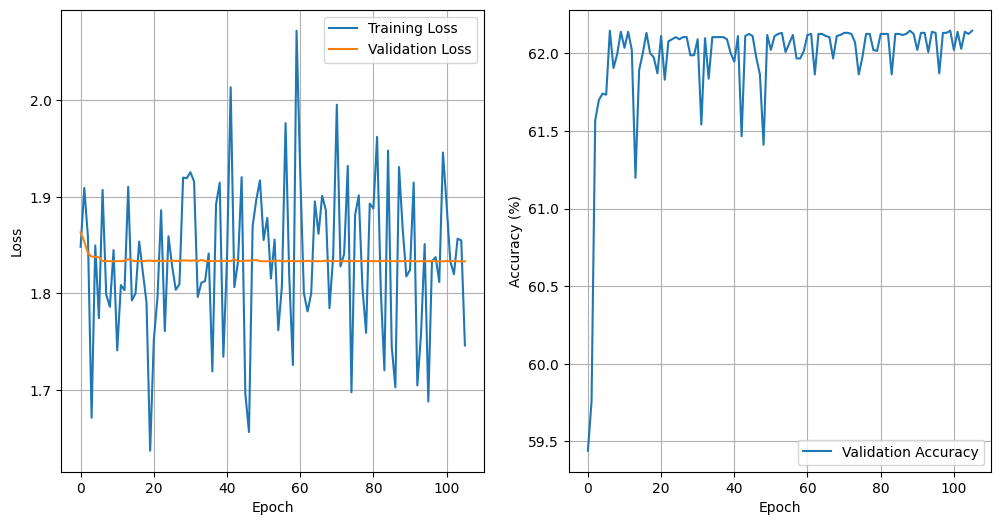

In [ ]:
# Plot the training and validation metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
model_c2 = ModelC2()

# Load the trained model
# model_c2.load_state_dict(torch.load('model.pt'))

# Make a prediction on a new data point
new_data = torch.randn(1024)
prediction = model_c2(new_data)

# Get the class with the highest probability
predicted_class = torch.argmax(prediction)

# Print the predicted class
print(predicted_class)